In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%pylab inline
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### multiple dwelling registration

You can find Multiple Dwelling Registration data including OwnerTypes and Site Manager information from the attached file. Followings are the description of columns:
* Owner: There is only 0. All BBLs of this data is living without owner in their buildings
* Ownership: Types of specific owners
    * Corp: Corporation (each unit is owned by individual owner)
    * Ind: Individual Owner
    * Off: Owned by company
    * Joint: Shared Owner (multiple owners)
    * Agent: Yes or No of representative agent of the building
    * SiteManager: Yes or No of site manager (super)
There are some NaN in "Agent" and "SiteManager" columns. 

You can replace those as 0 or drop. The results (before dropping and after dropping) were not that different. 

In [2]:
dwell = pd.read_csv('../data_processed/Multiple_Dwelling_Registration_OwnerType_Boiler_Joined.csv')
dwell = dwell.drop('Unnamed: 0',axis=1)
dwell.head()

,BBL,Owner,Ownership,Agent,SiteManager,boiler,boiler_age
0,4086640052,0,Ind,0.0,1.0,0,27.174765
1,4057400139,0,Corp,1.0,1.0,0,27.174765
2,3034570006,0,Corp,1.0,1.0,0,27.174765
3,1021160061,0,Corp,1.0,1.0,0,27.174765
4,1004360020,0,Corp,1.0,1.0,0,27.174765


In [3]:
dwell.boiler.unique()

array([0, 1, 2])

In [4]:
len(dwell)

147075

In [5]:
dwell = dwell.dropna()
dwell = dwell.drop('Owner',axis=1)

In [6]:
len(dwell)

144838

In [7]:
dwell.Ownership.unique()

array(['Ind', 'Corp', 'Off', 'Joint'], dtype=object)

In [8]:
dwell = pd.concat([dwell, pd.get_dummies(dwell['Ownership'])],axis=1)
dwell = pd.concat([dwell, pd.get_dummies(dwell['boiler'],prefix='boiler')],axis=1)

In [9]:
dwell.columns

Index([u'BBL', u'Ownership', u'Agent', u'SiteManager', u'boiler',
       u'boiler_age', u'Corp', u'Ind', u'Joint', u'Off', u'boiler_0',
       u'boiler_1', u'boiler_2'],
      dtype='object')

In [10]:
###identify majority class for dummy variables
print 'boiler_0:', len(dwell[dwell['boiler_0']==1])/float(len(dwell))
print 'boiler_1:', len(dwell[dwell['boiler_1']==1])/float(len(dwell))
print 'boiler_2:', len(dwell[dwell['boiler_2']==1])/float(len(dwell))
print 'corp own:',  len(dwell[dwell['Corp']==1])/float(len(dwell))
print 'individual own:',  len(dwell[dwell['Ind']==1])/float(len(dwell))
print 'joint own:',  len(dwell[dwell['Joint']==1])/float(len(dwell))
print 'off own:',  len(dwell[dwell['Off']==1])/float(len(dwell))

boiler_0: 0.989823112719
boiler_1: 0.00700092517157
boiler_2: 0.00317596210939
corp own: 0.503638547895
individual own: 0.333662436653
joint own: 0.133031386791
off own: 0.029667628661


Corporate ownership and boiler_0 are majority class, so will drop both as dummy reference.

In [11]:
###drop boiler_0, and Corp to use as reference columns
dwell = dwell.drop(['Ownership', 'boiler', 'boiler_0', 'Corp'],axis=1)

In [12]:
dwell.head()

,BBL,Agent,SiteManager,boiler_age,Ind,Joint,Off,boiler_1,boiler_2
0,4086640052,0.0,1.0,27.174765,1,0,0,0,0
1,4057400139,1.0,1.0,27.174765,0,0,0,0,0
2,3034570006,1.0,1.0,27.174765,0,0,0,0,0
3,1021160061,1.0,1.0,27.174765,0,0,0,0,0
4,1004360020,1.0,1.0,27.174765,0,0,0,0,0


### pluto

mapPLUTO
* AssessSqft
* UnitsRes
* ResArea
* ResArea_perunit
* Res_r
* NumFloors
* Bldg_nrr
* Bldg_age
* BsmtCode
* ProxCode
* BldgClass_dummy

In [13]:
pluto = pd.read_csv('../data_processed/pluto_16')
pluto = pluto.drop('Unnamed: 0',axis=1)
pluto.head()

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (27,37,40,46,53,64,65,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.0,NaN,437 PURDY AVENUE,R3-1,NaN,7,15120.0,23400.0,5.007470e+09,1488,...,0,1960,NaN,10314,R3-1,NaN,NaN,NaN,20d,"POLYGON ((944681.4200000018 161477.381400004, ..."
1,0.0,NaN,CUNARD AVENUE,R3A/HS,NaN,4,21518.0,21518.0,5.006230e+09,0,...,0,0,NaN,10304,R3A,NaN,NaN,NaN,21d,"POLYGON ((959872.0577999949 162992.5866000056,..."
2,0.0,NaN,121 MOUNTAINVIEW AVENUE,R3-1,NaN,7,13561.0,22602.0,5.007130e+09,1316,...,0,1920,NaN,10314,R3-1,NaN,NaN,NaN,21b,"POLYGON ((949278.1987999976 161346.9971999973,..."
3,0.0,NaN,26 FANNING STREET,R3X,NaN,7,9720.0,28740.0,5.007140e+09,2188,...,0,1975,NaN,10314,R3X,NaN,NaN,NaN,21b,"POLYGON ((950061.0491999984 160815.3023999929,..."
4,0.0,NaN,335 SIMONSON AVENUE,R3A,NaN,7,7617.0,22118.0,5.011840e+09,2392,...,0,1965,NaN,10303,R3A,NaN,NaN,NaN,20c,"POLYGON ((941981.4906000048 168120.2173999995,..."


#### remove outliers

In [14]:
pluto = pluto[pluto['YearBuilt']>1750]
pluto = pluto[pluto['AssessLand']> 0]
pluto = pluto[pluto['NumBldgs'] > 0]
pluto = pluto[pluto['NumFloors'] > 0]
pluto = pluto[pluto['ResArea'] > 0]
pluto = pluto[pluto['UnitsRes'] < 8000]
pluto = pluto[pluto['UnitsRes'] > 0]
pluto = pluto[pluto['BldgFront'] > 0]

#### adjust features

In [15]:
pluto['AssessSqft'] = pluto['AssessTot']/pluto['BldgArea']
pluto = pluto[pluto['AssessSqft'] > 0]

pluto['BldgAge'] = 2017-pluto['YearBuilt']
pluto = pluto.drop('YearBuilt',axis=1)

pluto['Bldg_nrr'] = pluto['BldgDepth']/pluto['BldgFront'].astype(float)

#proxcode
#0 = unknown, 1 = detatched, 2 = attached or semi=attached
pluto['ProxCode'] = pluto['ProxCode'].replace(3, 2)

#bsmtcode
#0 = no basement, 1 = full or partial basement, 5 = unknown
pluto['BsmtCode'] = pluto['BsmtCode'].replace(2, 1)
pluto['BsmtCode'] = pluto['BsmtCode'].replace(3, 1)
pluto['BsmtCode'] = pluto['BsmtCode'].replace(4, 1)
pluto['Res_r'] = pluto['ResArea']/pluto['BldgArea'].astype(float)
pluto['ResArea_perunit'] = pluto['ResArea']/pluto['UnitsRes'].astype(float)

bldgclass = []
for elem in pluto['BldgClass']:
    bldgclass.append(str(elem[0]))
bldgclasscat = []
for elem in bldgclass:
    if elem == 'A':
        bldgclasscat.append(1)
    elif elem == 'B':
        bldgclasscat.append(2)
    elif elem == 'C':
        bldgclasscat.append(3)
    elif elem == 'D':
        bldgclasscat.append(4)
    else:
        bldgclasscat.append(0)
pluto['BldgClass_dummy'] = bldgclasscat

In [16]:
pluto = pd.concat([pluto, pd.get_dummies(pluto['BldgClass_dummy'], prefix='bc'), \
                    pd.get_dummies(pluto['ProxCode'], prefix='pc'), \
                   pd.get_dummies(pluto['BsmtCode'], prefix='bsmt')],axis=1)

proxcode = []
for elem in pluto['ProxCode']:
    proxcode.append(elem)
proxcodecat = []
for elem in proxcode:
    if elem == 0:
        proxcodecat.append('pc0')
    elif elem == 1:
        proxcodecat.append('pc1')
    elif elem == 2:
        proxcodecat.append('pc2')
pluto['ProxCode_dummy'] = proxcodecat

bsmtcode = []
for elem in pluto['BsmtCode']:
    bsmtcode.append(elem)
bsmtcodecat = []
for elem in bsmtcode:
    if elem == 0:
        bsmtcodecat.append('bsmt0')
    elif elem == 1:
        bsmtcodecat.append('bsmt1')
    elif elem == 5:
        bsmtcodecat.append('bsmt5')
pluto['BsmtCode_dummy'] = bsmtcodecat

Pre 5/29/2017
BldgClass
 1: A (one family housing)
 2: B (two family housing)
 3: C + S (walk up + mixed use)
 4: D + O8 (elevator apartment + apt with office)
 5: R (condominium)
 6: L (loft)
 0: Others
 
Post 5/29/2017
BldgClass
 1: A (one family housing)
 2: B (two family housing)
 3: C (walk up)
 4: D (elevator apartment)
 0: Others (loft (L), mixed use (S), apt with office (O8), condo (R))

In [17]:
pluto.head(2)

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,bc_1,bc_2,bc_3,bc_4,pc_0.0,pc_1.0,pc_2.0,bsmt_0.0,bsmt_1.0,bsmt_5.0
0,0.0,NaN,437 PURDY AVENUE,R3-1,NaN,7,15120.0,23400.0,5.007470e+09,1488,...,0,1,0,0,0,1,0,0,1,0
2,0.0,NaN,121 MOUNTAINVIEW AVENUE,R3-1,NaN,7,13561.0,22602.0,5.007130e+09,1316,...,1,0,0,0,0,1,0,0,1,0


In [18]:
pluto.columns[20:]

Index([u'CD', u'CT2010', u'ComArea', u'CommFAR', u'CondoNo', u'Council',
       u'EDesigNum', u'Easements', u'ExemptLand', u'ExemptTot', u'Ext',
       u'FacilFAR', u'FactryArea', u'FireComp', u'GarageArea', u'HealthArea',
       u'HistDist', u'IrrLotCode', u'LandUse', u'Landmark', u'Lot', u'LotArea',
       u'LotDepth', u'LotFront', u'LotType', u'LtdHeight', u'MAPPLUTO_F',
       u'NumBldgs', u'NumFloors', u'OfficeArea', u'OtherArea', u'Overlay1',
       u'Overlay2', u'OwnerName', u'OwnerType', u'PLUTOMapID', u'PolicePrct',
       u'ProxCode', u'ResArea', u'ResidFAR', u'RetailArea', u'SHAPE_Area',
       u'SHAPE_Leng', u'SPDist1', u'SPDist2', u'Sanborn', u'SchoolDist',
       u'SplitZone', u'StrgeArea', u'TaxMap', u'Tract2010', u'UnitsRes',
       u'UnitsTotal', u'Version', u'XCoord', u'YCoord', u'YearAlter1',
       u'YearAlter2', u'ZMCode', u'ZipCode', u'ZoneDist1', u'ZoneDist2',
       u'ZoneDist3', u'ZoneDist4', u'ZoneMap', u'geometry', u'AssessSqft',
       u'BldgAge', u'Bldg_nrr

#### drop irrelevant features

In [19]:
###identify  majority class for bc, pc, and bsmt
print 'bc_0:', len(pluto[pluto['bc_0']==1])/float(len(pluto))
print 'bc_1:', len(pluto[pluto['bc_1']==1])/float(len(pluto))
print 'bc_2:', len(pluto[pluto['bc_2']==1])/float(len(pluto))
print 'bc_3:', len(pluto[pluto['bc_3']==1])/float(len(pluto))
print 'bc_4:', len(pluto[pluto['bc_4']==1])/float(len(pluto)), '\n'

print 'pc_0.0:', len(pluto[pluto['pc_0.0']==1])/float(len(pluto))
print 'pc_1.0:', len(pluto[pluto['pc_1.0']==1])/float(len(pluto))
print 'pc_2.0:', len(pluto[pluto['pc_2.0']==1])/float(len(pluto)), '\n'

print 'bsmt_0.0:', len(pluto[pluto['bsmt_0.0']==1])/float(len(pluto))
print 'bsmt_1.0:', len(pluto[pluto['bsmt_1.0']==1])/float(len(pluto))
print 'bsmt_5.0:', len(pluto[pluto['bsmt_5.0']==1])/float(len(pluto)), '\n'

bc_0: 0.0564150542771
bc_1: 0.418589590466
bc_2: 0.329113252117
bc_3: 0.178408578178
bc_4: 0.0174735249622 

pc_0.0: 0.096988879157
pc_1.0: 0.401743769408
pc_2.0: 0.501267351435 

bsmt_0.0: 0.0582570268333
bsmt_1.0: 0.846394351992
bsmt_5.0: 0.0953486211747 



In [20]:
###dropping bc_1, pc_2.0, and bsmt_1.0 to use as reference columns
pluto = pluto[['BBL', 'AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', \
              'bc_0', 'bc_2', 'bc_3', 'bc_4', 'pc_1.0', 'pc_0.0', 'bsmt_0.0', 'bsmt_5.0']]

### import violations

In [21]:
vios = pd.read_csv('../data_processed/VIOLATION_HEATHOTWATER_by_bbl_season.csv')
vios = vios.drop('Unnamed: 0',axis=1)

In [22]:
vios.head()

,BBL,Sum_season_vio,Avg_season_vio
0,1000160100,2,0.50
1,1000167509,1,0.25
2,1000170029,1,0.25
3,1000297501,1,0.25
4,1000530006,12,3.00


### view datasets

In [23]:
pluto.head()

,BBL,AssessSqft,UnitsRes,ResArea_perunit,Res_r,NumFloors,Bldg_nrr,BldgAge,bc_0,bc_2,bc_3,bc_4,pc_1.0,pc_0.0,bsmt_0.0,bsmt_5.0
0,5.007470e+09,15.725806,2,744.0,1.0,1.0,2.583333,57,0,1,0,0,1,0,0,0
2,5.007130e+09,17.174772,1,1316.0,1.0,2.5,1.588235,97,0,0,0,0,1,0,0,0
3,5.007140e+09,13.135283,2,1094.0,1.0,2.0,1.923077,42,0,1,0,0,1,0,1,0
4,5.011840e+09,9.246656,1,2392.0,1.0,2.0,1.769231,52,0,0,0,0,1,0,1,0
5,5.007650e+09,17.458111,1,1122.0,1.0,2.5,1.764706,92,0,0,0,0,1,0,0,0


In [24]:
pluto = pluto.reset_index()
pluto = pluto.drop('index',axis=1)

In [25]:
dwell.head()

,BBL,Agent,SiteManager,boiler_age,Ind,Joint,Off,boiler_1,boiler_2
0,4086640052,0.0,1.0,27.174765,1,0,0,0,0
1,4057400139,1.0,1.0,27.174765,0,0,0,0,0
2,3034570006,1.0,1.0,27.174765,0,0,0,0,0
3,1021160061,1.0,1.0,27.174765,0,0,0,0,0
4,1004360020,1.0,1.0,27.174765,0,0,0,0,0


In [26]:
vios.head()

,BBL,Sum_season_vio,Avg_season_vio
0,1000160100,2,0.50
1,1000167509,1,0.25
2,1000170029,1,0.25
3,1000297501,1,0.25
4,1000530006,12,3.00


In [27]:
print dwell.BBL.dtypes
print vios.BBL.dtypes
print pluto.BBL.dtypes

int64
int64
float64


In [28]:
print len(dwell)
print len(vios)
print len(pluto)

144838
17472
753540


### merge on BBL

In [29]:
pluto['BBL'] = pluto['BBL'].astype(int)

In [30]:
print dwell.BBL.dtypes
print vios.BBL.dtypes
print pluto.BBL.dtypes

int64
int64
int64


In [31]:
vios_dwell = pd.merge(vios, dwell, on='BBL', how='right')

In [32]:
vios_dwell.isnull().sum()

BBL                    0
Sum_season_vio    130185
Avg_season_vio    130185
Agent                  0
SiteManager            0
boiler_age             0
Ind                    0
Joint                  0
Off                    0
boiler_1               0
boiler_2               0
dtype: int64

In [33]:
vios_dwell = vios_dwell.replace(np.nan, 0)

In [34]:
dvp = pd.merge(pluto, vios_dwell, on='BBL', how='right')

In [35]:
dvp.isnull().sum()

BBL                   0
AssessSqft         5976
UnitsRes           5976
ResArea_perunit    5976
Res_r              5976
NumFloors          5976
Bldg_nrr           5976
BldgAge            5976
bc_0               5976
bc_2               5976
bc_3               5976
bc_4               5976
pc_1.0             5976
pc_0.0             5976
bsmt_0.0           5976
bsmt_5.0           5976
Sum_season_vio        0
Avg_season_vio        0
Agent                 0
SiteManager           0
boiler_age            0
Ind                   0
Joint                 0
Off                   0
boiler_1              0
boiler_2              0
dtype: int64

In [36]:
dvp  = dvp.dropna()

In [37]:
len(dvp)

138862

In [38]:
dvp['vio_binary'] = [1 if x > 0 else 0 for x in dvp['Avg_season_vio']]

#### descriptive analysis

In [39]:
dvp.describe()

,BBL,AssessSqft,UnitsRes,ResArea_perunit,Res_r,NumFloors,Bldg_nrr,BldgAge,bc_0,bc_2,...,Avg_season_vio,Agent,SiteManager,boiler_age,Ind,Joint,Off,boiler_1,boiler_2,vio_binary
count,1.388620e+05,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,...,138862.000000,138862.000000,138862.00000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000
mean,2.782979e+09,24.915142,14.520711,986.590534,0.950295,3.673191,2.424622,85.507259,0.119558,0.058396,...,0.090617,0.756002,0.80315,27.180528,0.344104,0.138303,0.030303,0.006877,0.002866,0.103340
std,1.034708e+09,31.273412,45.622941,1060.044417,0.126208,2.623617,1.535914,30.144591,0.324445,0.234492,...,0.447265,0.429493,0.39762,8.989871,0.475077,0.345219,0.171422,0.082644,0.053460,0.304404
min,1.000070e+09,0.315600,1.000000,26.000000,0.009232,1.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.037130e+09,9.665155,3.000000,745.000000,1.000000,2.500000,1.900000,86.000000,0.000000,0.000000,...,0.000000,1.000000,1.00000,27.174765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.023030e+09,14.950067,4.000000,900.000000,1.000000,3.000000,2.444444,92.000000,0.000000,0.000000,...,0.000000,1.000000,1.00000,27.174765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.071688e+09,26.052529,9.000000,1120.000000,1.000000,4.000000,3.000000,107.000000,0.000000,0.000000,...,0.000000,1.000000,1.00000,27.174765,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.080500e+09,3775.858779,5860.000000,330434.000000,15.071305,76.000000,331.823529,219.000000,1.000000,1.000000,...,20.250000,1.000000,1.00000,2012.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### continuous var relationship with dep

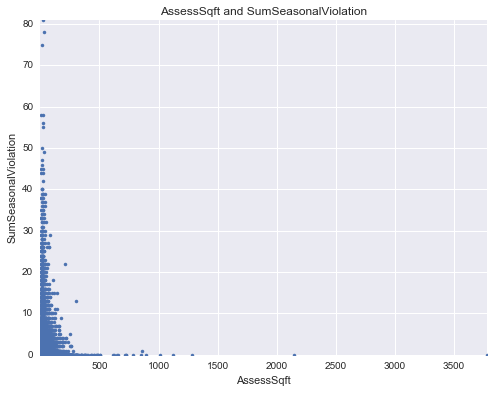

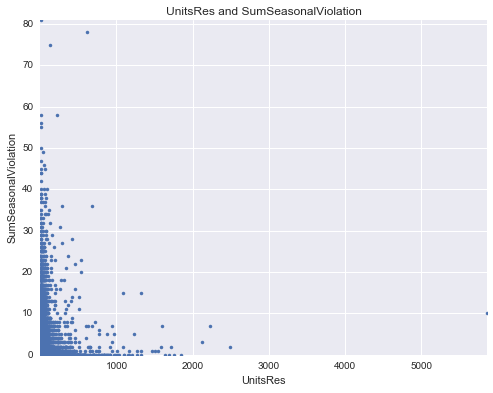

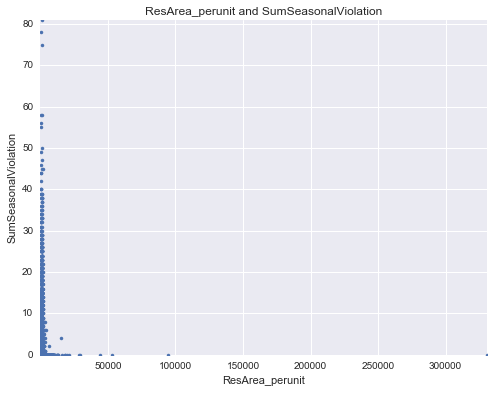

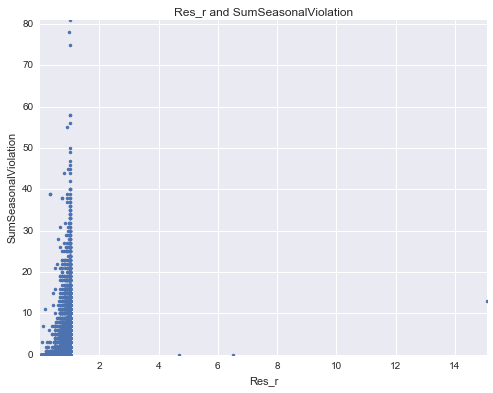

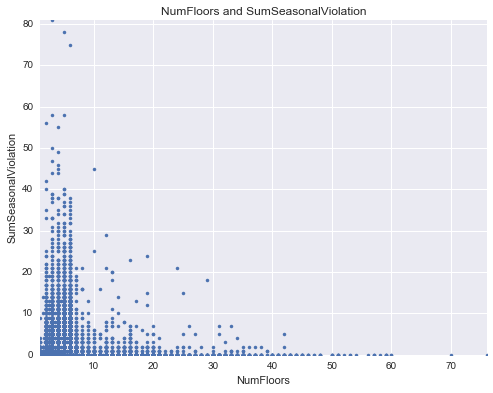

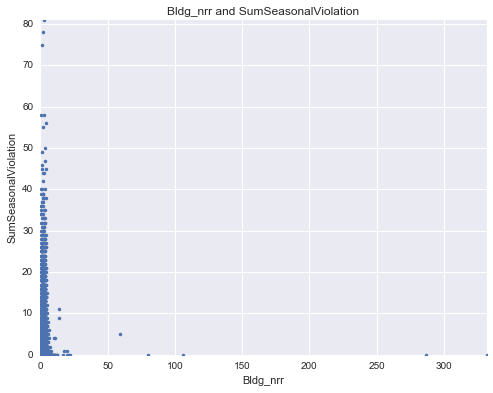

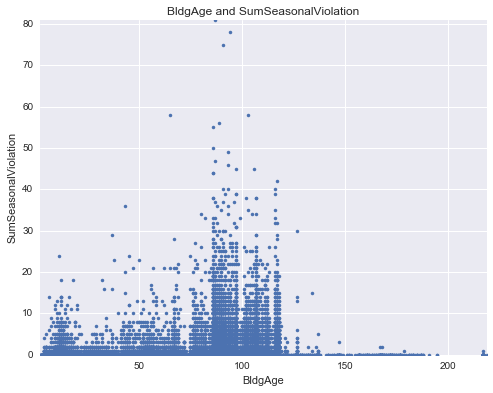

In [40]:
cols = ['AssessSqft','UnitsRes', 'ResArea_perunit','Res_r','NumFloors','Bldg_nrr',\
       'BldgAge']
for elem in cols:
    plt.figure(figsize=(8,6))
    plt.plot(dvp[elem],dvp['Sum_season_vio'], '.')
    plt.title(elem + ' and SumSeasonalViolation')
    plt.xlabel(elem)
    plt.ylabel('SumSeasonalViolation')
    plt.xlim(min(dvp[elem]),max(dvp[elem]))
    plt.ylim(min(dvp['Sum_season_vio']),max(dvp['Sum_season_vio']))

In [41]:
dvp_dropped = dvp.drop(['Avg_season_vio','Sum_season_vio'],axis=1)

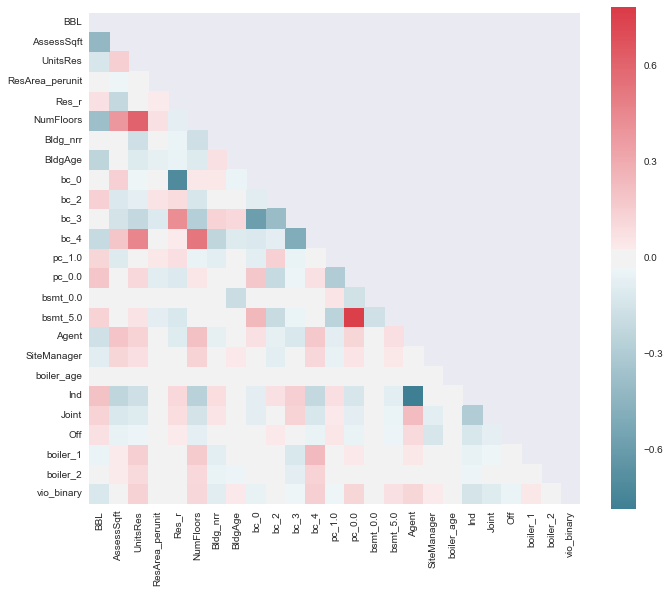

In [42]:
corr = dvp_dropped.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, ax=ax)


#### logistic regression

In [43]:
print len(dvp[dvp['vio_binary']==0])/float(len(dvp))
print len(dvp[dvp['vio_binary']==1])/float(len(dvp))

0.896659993375
0.103340006625


In [44]:
dvp.columns

Index([u'BBL', u'AssessSqft', u'UnitsRes', u'ResArea_perunit', u'Res_r',
       u'NumFloors', u'Bldg_nrr', u'BldgAge', u'bc_0', u'bc_2', u'bc_3',
       u'bc_4', u'pc_1.0', u'pc_0.0', u'bsmt_0.0', u'bsmt_5.0',
       u'Sum_season_vio', u'Avg_season_vio', u'Agent', u'SiteManager',
       u'boiler_age', u'Ind', u'Joint', u'Off', u'boiler_1', u'boiler_2',
       u'vio_binary'],
      dtype='object')

The percentage of correctly classified datapoints, or accuracy, can be calculated with the following formula: ACC = (TP + TN) / (TP + TN + FP + FN). The percentage of incorrectly classified datapoints over the test set can be calculated with the following formula: (FP + FN) / (TP + TN + FP + FN), or 1 - ACC.

In [45]:
X = dvp.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'bc_0', 'bc_2', \
               'bc_3', 'bc_4', 'pc_1.0', 'pc_0.0', \
               'bsmt_0.0', 'bsmt_5.0', 'Agent', 'SiteManager', \
               'boiler_age', 'Ind', 'Joint', 'Off', 'boiler_1', 'boiler_2']]
y = dvp.loc[:,['vio_binary']]
is_rsquared = []
os_acc = []
os_inacc = []
TN = []
FN = []
TP = []
FP = []
for i in np.arange(1,300,20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    mod = smf.Logit(y_train, X_train)
    res = mod.fit()
    is_rsquared.append(res.prsquared)
    y_pred = res.predict(X_test)
    results = pd.concat([y_test,y_pred],axis=1)
    results = results.rename(columns={0:'y_pred'})
    results['vio_pred'] = [1 if x >= 0.5 else 0 for x in y_pred]
    confusion = confusion_matrix(results['vio_binary'], results['vio_pred'])
    TN.append(confusion[0][0])
    FN.append(confusion[1][0])
    TP.append(confusion[1][1])
    FP.append(confusion[0][1])
    os_acc.append((confusion[1][1]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
    os_inacc.append((confusion[1][0]+confusion[0][1])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
print 'Average in sample psuedo rsquared: '+str(np.mean(is_rsquared))
print 'Average percentage of correctly classified out of sample data points: '+str(np.mean(os_acc))
print 'Average percentage of incorrectly classified out of sample data points: '+str(np.mean(os_inacc))
print 'Average FP: '+str(np.mean(FP))
print 'Average FN: '+str(np.mean(FN))
print 'TN: ', confusion[0][0]
print 'FN:', confusion[1][0]
print 'TP: ', confusion[1][1]
print 'FP: ', confusion[0][1]
print 'Sensitivity: '+str(confusion[1][1]/float((confusion[1][1]+confusion[1][0])))
print 'Precision: '+str(confusion[1][1]/float((confusion[1][1]+confusion[0][1])))
print confusion

Optimization terminated successfully.
         Current function value: 0.287246
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.287681
         Iterations 8
         Current function value: 0.288462
         Iterations: 35


/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.288592
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.287362
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289077
         Iterations 8
         Current function value: 0.286001
         Iterations: 35


/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.289351
         Iterations: 35


/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.286648
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.288498
         Iterations 8
         Current function value: 0.290751
         Iterations: 35


/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.287921
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.288524
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.288302
         Iterations 8
Average in sample psuedo rsquared: 0.133689520622
Average percentage of correctly classified out of sample data points: 0.896768139662
Average percentage of incorrectly classified out of sample data points: 0.103231860338
Average FP: 38.1333333333
Average FN: 4692.46666667
TN:  41061
FN: 4686
TP:  37
FP:  41
Sensitivity: 0.00783400381114
Precision: 0.474358974359
[[41061    41]
 [ 4686    37]]


/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.765545833403


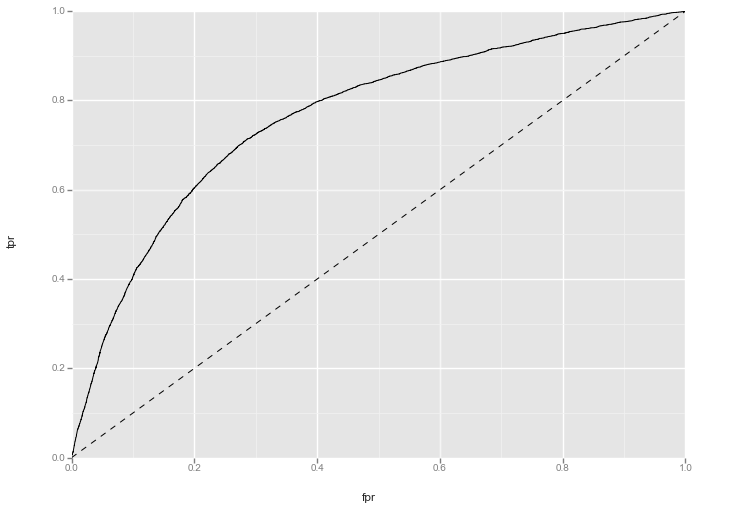

<ggplot: (295361969)>

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from ggplot import *
X = dvp.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'bc_0', 'bc_2', \
               'bc_3', 'bc_4', 'pc_1.0', 'pc_0.0', \
               'bsmt_0.0', 'bsmt_5.0', 'Agent', 'SiteManager', \
               'boiler_age', 'Ind', 'Joint', 'Off', 'boiler_1', 'boiler_2']]
y = dvp.loc[:,['vio_binary']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)
clf = LogisticRegression()
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
print metrics.roc_auc_score(y_test, preds)
ggplot(df, aes(x='fpr', y='tpr'))+geom_line()+geom_abline(linetype='dashed')

#### try logistic regression with undersampling the majority class

In [47]:
is_rsquared = []
os_acc = []
os_inacc = []
TN = []
FN = []
TP = []
FP = []
odds = []
pvalues = []
for i in np.arange(1,300,20):
    zeros = dvp[dvp['vio_binary']==0]
    sample_zeros = zeros.sample(n=len(dvp[dvp['vio_binary']==1]))
    newdf = pd.concat([dvp[dvp['vio_binary']==1], sample_zeros])
    X = newdf.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'bc_0', 'bc_2', \
               'bc_3', 'bc_4', 'pc_1.0', 'pc_0.0', \
               'bsmt_0.0', 'bsmt_5.0', 'Agent', 'SiteManager', \
               'boiler_age', 'Ind', 'Joint', 'Off', 'boiler_1', 'boiler_2']]
    y = newdf.loc[:,['vio_binary']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    mod = smf.Logit(y_train, X_train)
    res = mod.fit()
    odds.append(np.exp(res.params))
    pvalues.append(res.pvalues)
    is_rsquared.append(res.prsquared)
    y_pred = res.predict(X_test)
    results = pd.concat([y_test,y_pred],axis=1)
    results = results.rename(columns={0:'y_pred'})
    results['vio_pred'] = [1 if x >= 0.5 else 0 for x in y_pred]
    confusion = confusion_matrix(results['vio_binary'], results['vio_pred'])
    TN.append(confusion[0][0])
    FN.append(confusion[1][0])
    TP.append(confusion[1][1])
    FP.append(confusion[0][1])
    os_acc.append((confusion[1][1]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
    os_inacc.append((confusion[1][0]+confusion[0][1])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
print 'Average in sample psuedo rsquared: '+str(np.mean(is_rsquared))
print 'Average percentage of correctly classified out of sample data points: '+str(np.mean(os_acc))
print 'Average percentage of incorrectly classified out of sample data points: '+str(np.mean(os_inacc))
print 'Average FP: '+str(np.mean(FP))
print 'Average FN: '+str(np.mean(FN))
print 'TN: ', confusion[0][0]
print 'FN:', confusion[1][0]
print 'TP: ', confusion[1][1]
print 'FP: ', confusion[0][1]
print 'Sensitivity: '+str(confusion[1][1]/float((confusion[1][1]+confusion[1][0])))
print 'Precision: '+str(confusion[1][1]/float((confusion[1][1]+confusion[0][1])))
print confusion
pvaluedf = pd.concat([elem for elem in pvalues],axis=1)
pvaluedf['avg_pvalue'] = pvaluedf.mean(axis=1)
pvaluedf = pvaluedf.reset_index()
pvaluedf = pvaluedf[['index','avg_pvalue']]
pvaluedf = pvaluedf.rename(columns={'index':'variable_name'})
pvaluedf['avg_pvalue'] = pvaluedf['avg_pvalue'].map('{:,.4f}'.format)

oddsdf = pd.concat([elem for elem in odds],axis=1)
oddsdf['avg_oddsratio'] = oddsdf.mean(axis=1)
oddsdf = oddsdf.reset_index()
oddsdf = oddsdf[['index','avg_oddsratio']]
oddsdf = oddsdf.rename(columns={'index':'variable_name'})
oddsdf['avg_oddsratio'] = oddsdf['avg_oddsratio'].map('{:,.4f}'.format)

Optimization terminated successfully.
         Current function value: 0.579402
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.580620
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.575532
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.578174
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.582380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.581842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581297
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579252
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.577223
  

In [48]:
pvaluedf

,variable_name,avg_pvalue
0,AssessSqft,0.0000
1,UnitsRes,0.0000
2,ResArea_perunit,0.0000
3,Res_r,0.0421
4,NumFloors,0.0890
5,Bldg_nrr,0.0000
6,BldgAge,0.0000
7,bc_0,0.0112
8,bc_2,0.0082
9,bc_3,0.1984


In [49]:
oddsdf

,variable_name,avg_oddsratio
0,AssessSqft,0.9880
1,UnitsRes,1.0044
2,ResArea_perunit,0.9994
3,Res_r,0.6135
4,NumFloors,1.0345
5,Bldg_nrr,0.8770
6,BldgAge,1.0064
7,bc_0,0.5756
8,bc_2,1.7304
9,bc_3,1.3308


0.774278481905


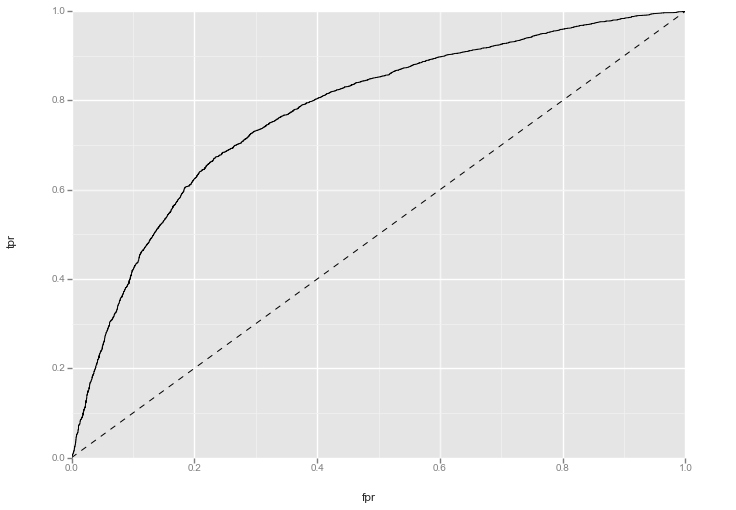

<ggplot: (295733861)>

In [50]:
zeros = dvp[dvp['vio_binary']==0]
sample_zeros = zeros.sample(n=len(dvp[dvp['vio_binary']==1]))
newdf = pd.concat([dvp[dvp['vio_binary']==1], sample_zeros])
X = newdf.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'bc_0', 'bc_2', \
               'bc_3', 'bc_4', 'pc_1.0', 'pc_0.0', \
               'bsmt_0.0', 'bsmt_5.0', 'Agent', 'SiteManager', \
               'boiler_age', 'Ind', 'Joint', 'Off', 'boiler_1', 'boiler_2']]
y = newdf.loc[:,['vio_binary']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)
clf = LogisticRegression()
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
print metrics.roc_auc_score(y_test, preds)
ggplot(df, aes(x='fpr', y='tpr'))+geom_line()+geom_abline(linetype='dashed')

#### try logistic with oversampling minority class

In [51]:
X = dvp.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'bc_0', 'bc_2', \
               'bc_3', 'bc_4', 'pc_1.0', 'pc_0.0', \
               'bsmt_0.0', 'bsmt_5.0', 'Agent', 'SiteManager', \
               'boiler_age', 'Ind', 'Joint', 'Off', 'boiler_1', 'boiler_2']]
y = dvp.loc[:,['vio_binary']]
is_rsquared = []
os_acc = []
os_inacc = []
TN = []
FN = []
TP = []
FP = []
for i in np.arange(1,300,20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    sm = SMOTE(random_state=i, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    mod = smf.Logit(y_train_res, X_train_res)
    res = mod.fit()
    is_rsquared.append(res.prsquared)
    y_pred = res.predict(X_test)
    results = pd.concat([y_test,y_pred],axis=1)
    results = results.rename(columns={0:'y_pred'})
    results['vio_pred'] = [1 if x >= 0.5 else 0 for x in y_pred]
    confusion = confusion_matrix(results['vio_binary'], results['vio_pred'])
    TN.append(confusion[0][0])
    FN.append(confusion[1][0])
    TP.append(confusion[1][1])
    FP.append(confusion[0][1])
    os_acc.append((confusion[1][1]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
    os_inacc.append((confusion[1][0]+confusion[0][1])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
print 'Average in sample psuedo rsquared: '+str(np.mean(is_rsquared))
print 'Average percentage of correctly classified out of sample data points: '+str(np.mean(os_acc))
print 'Average percentage of incorrectly classified out of sample data points: '+str(np.mean(os_inacc))
print 'Average FP: '+str(np.mean(FP))
print 'Average FN: '+str(np.mean(FN))
print 'TN: ', confusion[0][0]
print 'FN:', confusion[1][0]
print 'TP: ', confusion[1][1]
print 'FP: ', confusion[0][1]
print 'Sensitivity: '+str(confusion[1][1]/float((confusion[1][1]+confusion[1][0])))
print 'Precision: '+str(confusion[1][1]/float((confusion[1][1]+confusion[0][1])))
print confusion

Optimization terminated successfully.
         Current function value: 0.569321
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.571365
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.570898
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.569001
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.569132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571059
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.572651
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.571701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.570901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.567685
  

0.767463398043


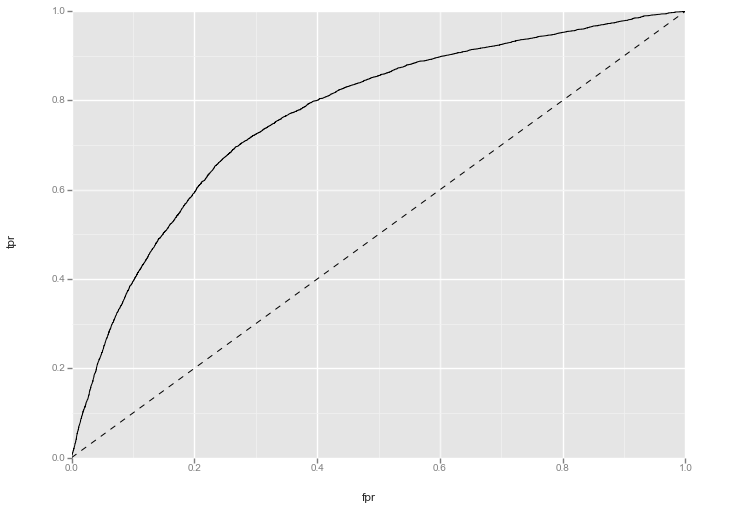

<ggplot: (295733981)>

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)
sm = SMOTE(random_state=i, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
clf = LogisticRegression()
clf.fit(X_train_res, y_train_res)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
print metrics.roc_auc_score(y_test, preds)
ggplot(df, aes(x='fpr', y='tpr'))+geom_line()+geom_abline(linetype='dashed')